In [1]:
from keras.applications import MobileNet

#
# Goal of transfer learning: reuse existing neural net to learn new classes
# (new = not in the original classes!)
#
#

# featurizer (frozen) + classifier (new!)

image_height = image_width = 160 # pixels (alternatively 224)
channels = 3 # RGB

featurizer = MobileNet(input_shape=(image_height, image_width, channels),
                       include_top=False) # drop the classifier part
featurizer.summary()

/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


17227776/17225924 [==============================] - 35s 2us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
_________________________________________________________________
conv_dw_1_

In [7]:
# Get the input from the folder
# Data Augmentation: rotate, flip horizontal (but not vertical)
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=45.0, horizontal_flip=True, # mirror image ok
                         zoom_range=3., # RGB pixels 0-255 => 0-1 range (training)
                         preprocessing_function=preprocess_input) # apply MobileNet preprocessing

it = gen.flow_from_directory('data/train', target_size=(image_height, image_width),
                             batch_size=45) # 15 images x 3 classes
                        
X_train, y_train = next(it) # gets 1 batch of 45 images

Found 45 images belonging to 3 classes.


In [8]:
# Transform X_train to features
#
# 1. images (45), labels (45) => |Featurizer| => features (45 rows, 5x5x1024 features)
#
# 2. fit classifier using features and labels (y_train)
#
# 3. predict
#
#

# 1. images (45), labels (45) => |Featurizer| => features (45 rows, 5x5x1024 features)
X_train_features = featurizer.predict(X_train)
print(X_train_features.shape) # 45, 5, 5, 1024


(45, 5, 5, 1024)


In [9]:
# 2. fit classifier using features and labels (y_train)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

classifier = Sequential()
classifier.add(Flatten(input_shape=X_train_features.shape[1:])) # 5,5,1024 -> 5*5*1024

# input 5*5*1024 nodes, output 64 nodes (32, 128)
# 1638464 = 25600 (input) x 64 (output) + 64 (bias)
classifier.add(Dense(64, activation='relu')) # first fully-connected layer

classifier.add(Dropout(0.5)) # to prevent overfitting, randomly drop some nodes

# 3 classes! softmax: 0-1, multi-class, probability
# 2 classes? sigmoid
# 195 = 64 (input) * 3 (output) + 3 (bias)
classifier.add(Dense(3, activation='softmax')) # second fully-connected layer

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1638464   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,638,659
Trainable params: 1,638,659
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import time

# Keras training
# compile
classifier.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# setup callbacks (optional): tensorboard, early stopping, model checkpoint
tensorboard = TensorBoard(log_dir='logs/classifier/%d' % time.time())
earlystop = EarlyStopping(patience=2)

# fit
classifier.fit(X_train_features, y_train, epochs=50,
               callbacks=[tensorboard, earlystop],
               validation_split=0.1)

Train on 40 samples, validate on 5 samples
Epoch 1/50
40/40 [==============================] - 0s 5ms/step - loss: 4.2321e-04 - acc: 1.0000 - val_loss: 2.3226 - val_acc: 0.8000
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.4551 - acc: 0.9500 - val_loss: 2.2360 - val_acc: 0.8000
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 4.2693e-04 - acc: 1.0000 - val_loss: 2.4407 - val_acc: 0.8000
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2620 - acc: 0.9750 - val_loss: 2.6630 - val_acc: 0.8000


In [14]:
# 3. predict from directory
from sklearn.metrics import classification_report, confusion_matrix

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen_dir = test_gen.flow_from_directory('data/validation/',
                                           target_size=(image_height, image_width),
                                           batch_size=15) # 15 validation images
X_test, y_test = next(test_gen_dir) # returns batch_size

X_test_features = featurizer.predict(X_test) # get features

y_pred = classifier.predict(X_test_features) # call classifier

y_test_labels = y_test.argmax(axis=1) # one-hot -> labels
y_pred_labels = y_pred.argmax(axis=1) # one-hot -> labels
# print(classifier.predict_classes(X_test_features)) # also returns labels

print(classification_report(y_test_labels, y_pred_labels))
print(confusion_matrix(y_test_labels, y_pred_labels))

Found 15 images belonging to 3 classes.
             precision    recall  f1-score   support

          0       0.83      1.00      0.91         5
          1       0.83      1.00      0.91         5
          2       1.00      0.60      0.75         5

avg / total       0.89      0.87      0.86        15

[[5 0 0]
 [0 5 0]
 [1 1 3]]


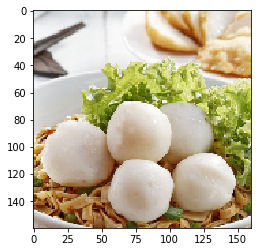

In [16]:
# 3. predict from image URL
labels = ['chapati', 'fishball_noodle', 'satay']

import requests # (mldds03) pip install requests or conda install requests
from PIL import Image, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt

url = 'https://enciktan.com.sg/wp-content/uploads/2015/01/set-b-500x300.jpg'
response = requests.get(url) # download from URL
img = Image.open(BytesIO(response.content))
img = ImageOps.fit(img, (image_width, image_height)) # crop to 160x160 (match training pre-processing)

plt.imshow(img)
plt.show()

In [18]:
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet import preprocess_input

import numpy as np

# Converts a PIL Image instance to a Numpy array.
x_test = img_to_array(img)
x_test = preprocess_input(x_test)
x_test = np.expand_dims(x_test, axis=0) # adds 1 extra dimension in the 0th axis

x_test_features = featurizer.predict(x_test)
y_pred_labels_1 = classifier.predict_classes(x_test_features) # returns 1 label
y_prob = classifier.predict(x_test_features) # returns 3 probabilities

print(labels[y_pred_labels_1[0]], y_prob[0][y_pred_labels_1[0]])
print(y_prob)

fishball_noodle 0.9999864
[[3.3997601e-06 9.9998641e-01 1.0083489e-05]]


In [19]:
# save classifier weights and structure
classifier.save(filepath='classifier.hdf5')

satay 0.99860173
[[6.3506348e-05 1.3347100e-03 9.9860173e-01]]


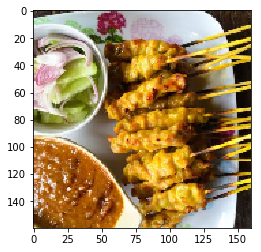

In [21]:
from keras.models import load_model
from keras.applications.mobilenet import preprocess_input

# 3. predict from image URL
labels = ['chapati', 'fishball_noodle', 'satay']

#url = 'https://enciktan.com.sg/wp-content/uploads/2015/01/set-b-500x300.jpg'
url = 'https://www.irishtimes.com/polopoly_fs/1.2854640.1478261927!/image/image.jpg_gen/derivatives/landscape_620/image.jpg'
#url = 'https://enciktan.com.sg/wp-content/uploads/2015/01/kaya-pau-500x300.jpg'

response = requests.get(url) # download from URL
img = Image.open(BytesIO(response.content))
img = ImageOps.fit(img, (image_width, image_height)) # crop to 160x160 (match training pre-processing)
plt.imshow(img)

# Converts a PIL Image instance to a Numpy array.
x_test = img_to_array(img)
x_test = preprocess_input(x_test)

x_test = np.expand_dims(x_test, axis=0) # adds 1 extra dimension in the 0th axis

classifier2 = load_model('classifier.hdf5') # load from saved model

x_test_features = featurizer.predict(x_test)
y_pred_labels_1 = classifier2.predict_classes(x_test_features) # returns 1 label
y_prob = classifier2.predict(x_test_features) # returns 3 probabilities

print(labels[y_pred_labels_1[0]], y_prob[0][y_pred_labels_1[0]])
print(y_prob)

```
# Simple Transfer Learning

gen = ImageDataGenerator(rotation_range=45.0, horizontal_flip=True,
        zoom_range=3., preprocessing_function=preprocess_input) 

it = gen.flow_from_directory('data/train', target_size=(image_height, image_width),
                             batch_size=45) # 15 images x 3 classes
                       
X_train, y_train = next(it) # gets 1 batch of 45 images

# 1. images (45), labels (45) => |Featurizer| => features (45 rows, 5x5x1024 features)
featurizer = MobileNet(include_top=False, weights='imagenet', input_shape=(image_width, image_height, channels))

# 2. fit classifier using features and labels (y_train)
classifier = Sequential()
classifier.add(Flatten(input_shape=X_train_features.shape[1:])) # 5,5,1024 -> 5*5*1024
classifier.add(Dense(64, activation='relu')) # first fully-connected layer
classifier.add(Dropout(0.5)) # to prevent overfitting, randomly drop some nodes
classifier.add(Dense(3, activation='softmax')) # second fully-connected layer

tensorboard = TensorBoard(log_dir='logs/classifier/%d' % time.time())
earlystop = EarlyStopping(patience=2)

classifier.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

X_train_features = featurizer.predict(X_train)

classifier.fit(X_train_features, y_train, epochs=50,
               callbacks=[tensorboard, earlystop],
               validation_split=0.1)
```

```
# Transfer Learning + Fine-Tuning
# Run this after training classifier

gen = ImageDataGenerator(rotation_range=45.0, horizontal_flip=True, # mirror image ok
     zoom_range=3., preprocessing_function=preprocess_input)

it = gen.flow_from_directory('data/train', target_size=(image_height, image_width), batch_size=45)

X_train, y_train = next(it) # gets 1 batch of 45 images

featurizer2 = MobileNet(include_top=False, weights='imagenet', input_shape=(image_width, image_height, channels))

# classifier must be pre-trained (from simple transfer learning)
combined_model = Model(inputs=featurizer2.input, outputs=classifier(featurizer2.output))

for layer in combined_model.layers[:-7]:
    layer.trainable = False # freeze weights for this layer

tensorboard = TensorBoard(log_dir='logs/finetuning/%d' % time.time())
earlystop = EarlyStopping(patience=2)

combined_model.compile(SGD(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Combined Model = Featurizer + Classifier
combined_model.fit(X_train, y_train, epochs=50, callbacks=[tensorboard, earlystop], validation_split=0.1)

# Save model if you need to retrain or deploy
combined_model.save('combined.hdf5')

# later.... (retrain)
# combined_model2 = load_model('combined.hdf5')
# combined_model2.fit(...)
```

In [ ]:
# If want to add to 1000 classes

# 1. 2-stage classifier. 1000 class, then 3 class
#  a) image -> Full ImageNet classifier (MobileNet, VGG) -> prediction (1000)
#     best class, or threshold < 40% => no class
#   class probabilities: [0.25, 0.13, ...]
#  b) If threshold < 40% (not one of the 1000 classes): image -> Featurzier + Classifier (3 classes) -> 1 out of 3 classes
#     Else use best class from a)

# 2. Retrain Classifier with 1000+3 classes
#    Collect images for 1000+3 classes (15-20 per class, use from imagenet dataset for the 1000) 
#    Transfer learning: featurizer + classifer without finetune
#